

In this notebook, we'll build a federated learning system for brain tumour classification using Flower and PyTorch. We use PyTorch for the model training pipeline and data loading and we continue to federate the PyTorch-based pipeline using Flower.


## Step 0: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`), Flower Datasets (`flwr-datasets`) and Flower (`flwr`):

In [2]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
ERROR: pip's dependency

In [3]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
#from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
#from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
#disable_progress_bar()

Training on cuda using PyTorch 2.3.0+cu121 and Flower 1.9.0


In [ ]:
DEVICE = torch.device("cuda")

In [ ]:
pip install datasets.utils

ERROR: Could not find a version that satisfies the requirement datasets.utils (from versions: none)
ERROR: No matching distribution found for datasets.utils
Note: you may need to restart the kernel to use updated packages.


We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original brain tumour dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server.


 We will create small training and test set for each edge device and wrap each of them into a PyTorch `DataLoader`:

In [13]:


import os

dataset_train_path = "/content/drive/MyDrive/datasets/brain-tumour-dataset/Training"
dataset_test_path = "/content/drive/MyDrive/datasets/brain-tumour-dataset/Testing"

def count_images_in_folders(path):
    # Initialize a dictionary to store folder names and their corresponding image counts
    folder_image_counts = {}

    # Iterate through each folder in the specified path
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Count the number of files (assuming they are all images)
            num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

            # Store the folder name and its image count in the dictionary
            folder_image_counts[folder_name] = num_images

    return folder_image_counts

# Count images in training dataset folders
train_counts = count_images_in_folders(dataset_train_path)
print("Number of images in each folder in Training dataset:")
for folder, count in train_counts.items():
    print(f"{folder}: {count} images")

print()

# Count images in testing dataset folders
test_counts = count_images_in_folders(dataset_test_path)
print("Number of images in each folder in Testing dataset:")
for folder, count in test_counts.items():
    print(f"{folder}: {count} images")


Number of images in each folder in Training dataset:
no_tumor: 395 images
glioma_tumor: 826 images
meningioma_tumor: 842 images
pituitary_tumor: 827 images

Number of images in each folder in Testing dataset:
meningioma_tumor: 115 images
pituitary_tumor: 74 images
no_tumor: 105 images
glioma_tumor: 100 images


## Step 1: Centralized Training with PyTorch



Next, we're going to use PyTorch to define a simple convolutional neural network.

### Defining the model

We use the simple CNN described using Pytorch

In [5]:
pip install torchsummary


In [6]:
from torchsummary import summary

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Input channels: 3 (RGB), Output channels: 16, Kernel size: 3x3, Padding: 1
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # Input channels: 16, Output channels: 32, Kernel size: 3x3, Padding: 1
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # Input channels: 32, Output channels: 64, Kernel size: 3x3, Padding: 1
        # Define pooling layer
        self.pool = nn.MaxPool2d(2, 2) # Max pooling with kernel size 2x2 and stride 2
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 512)  # Input size: 64*28*28, Output size: 512
        self.fc2 = nn.Linear(512, 128)           # Input size: 512, Output size: 128
        self.fc3 = nn.Linear(128, 4)             # Input size: 128, Output size: 4 (assuming 4 classes)

    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply the second convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Apply the third convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 64 * 28 * 28)
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        # Apply the final fully connected layer
        x = self.fc3(x)
        return x



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
model = Net()

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Linear-7                  [-1, 512]      25,690,624
            Linear-8                  [-1, 128]          65,664
            Linear-9                    [-1, 4]             516
Total params: 25,780,388
Trainable params: 25,780,388
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 13.40
Params size (MB): 98.34
Estimated Total Size (MB): 112.32
---------------------------------

Let's continue with the usual training and test functions:

In [ ]:
def train(net, trainloader, epochs:int, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    net.train()

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)  # Ensure targets are in the correct shape
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            epoch_loss += loss.item()

        accuracy = correct / total
        epoch_loss /= len(trainloader)

        if verbose:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    print("Test acc ", accuracy)
    return loss, accuracy




### Training the model

We now have all the basic building blocks we need: a dataset, a model, a training function, and a test function. Let's put them together to train the model on the dataset of one of our organizations (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data:

In [ ]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

NUM_CLIENTS = 6
BATCH_SIZE = 48

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full training dataset
train_dataset = ImageFolder(root=dataset_train_path, transform=transform)

# Calculate the size of each client's subset
subset_size = len(train_dataset) // NUM_CLIENTS
print("Number of training samples:", len(train_dataset))
print(subset_size)

Number of training samples: 2880
480


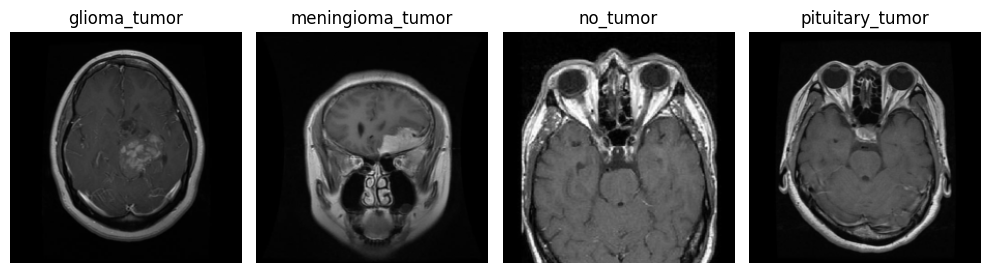

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the paths to the training dataset
dataset_train_path = "/content/drive/MyDrive/datasets/brain-tumour-dataset/Training"

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the training dataset
train_dataset = datasets.ImageFolder(root=dataset_train_path, transform=transform)

# Get the class names
class_names = train_dataset.classes

# Create a dictionary to store one image from each class
class_images = {}

# Loop through the training dataset to find one image from each class
for i, (image, label) in enumerate(train_dataset):
    if class_names[label] not in class_images:
        class_images[class_names[label]] = image
    if len(class_images) == len(class_names):
        break

# Plot one image from each class
plt.figure(figsize=(10, 5))
for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(1, len(class_names), i+1)
    plt.title(class_name)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

trainloaders = []
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)  # Shuffle the indices randomly

subset_size = len(train_dataset) // NUM_CLIENTS

for i in range(NUM_CLIENTS):
    # Determine the indices for the subset of the dataset for this client
    start_index = i * subset_size
    end_index = (i + 1) * subset_size
    subset_indices = indices[start_index:end_index]  # Use shuffled indices

    subset = Subset(train_dataset, subset_indices)

    # Create a DataLoader for this client using the subset
    trainloader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
    trainloaders.append(trainloader)

In [ ]:

"""
# Create DataLoader instances for each client
trainloaders = []
for i in range(NUM_CLIENTS):
    # Determine the indices for the subset of the dataset for this client
    start_index = i * subset_size
    end_index = start_index + subset_size
    subset_indices = list(range(start_index, end_index))
    subset = Subset(train_dataset, subset_indices)

    # Create a DataLoader for this client using the subset
    trainloader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=True)
    trainloaders.append(trainloader)
"""
# Load the testing dataset
test_dataset = ImageFolder(root=dataset_test_path, transform=transform)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Display information about the testloader
print("Number of testing samples:", len(test_dataset))
print("Number of classes:", len(test_dataset.classes))

# Display a sample batch from the testloader
sample_images, sample_labels = next(iter(testloader))
print("Sample images shape:", sample_images.shape)
print("Sample labels shape:", sample_labels.shape)


# Display sample batch from training DataLoader
for batch in trainloader:
    images, labels = batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break  # Only print the first batch


Number of testing samples: 394
Number of classes: 4
Sample images shape: torch.Size([48, 3, 224, 224])
Sample labels shape: torch.Size([48])
Image batch shape: torch.Size([48, 3, 224, 224])
Label batch shape: torch.Size([48])


In [ ]:
trainloader = trainloaders[0]
valloader = testloader
net = Net().to(DEVICE)

for epoch in range(10):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")



Epoch 1/1, Loss: 1.1212, Accuracy: 0.4847
Test acc  0.2918781725888325
Epoch 1: validation loss 0.0820971753088956, accuracy 0.2918781725888325
Epoch 1/1, Loss: 0.6886, Accuracy: 0.5521
Test acc  0.27411167512690354
Epoch 2: validation loss 0.09639668903375034, accuracy 0.27411167512690354
Epoch 1/1, Loss: 0.6789, Accuracy: 0.5889
Test acc  0.2715736040609137
Epoch 3: validation loss 0.1047167101789852, accuracy 0.2715736040609137
Epoch 1/1, Loss: 0.6639, Accuracy: 0.6146
Test acc  0.3147208121827411
Epoch 4: validation loss 0.11605328775299383, accuracy 0.3147208121827411
Epoch 1/1, Loss: 0.6757, Accuracy: 0.5854
Test acc  0.2969543147208122
Epoch 5: validation loss 0.10046910105017841, accuracy 0.2969543147208122
Epoch 1/1, Loss: 0.6415, Accuracy: 0.6403
Test acc  0.3096446700507614
Epoch 6: validation loss 0.1171750231140156, accuracy 0.3096446700507614
Epoch 1/1, Loss: 0.6261, Accuracy: 0.6500
Test acc  0.30456852791878175
Epoch 7: validation loss 0.11990071432239513, accuracy 0.30

In [ ]:
loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Test acc  0.30710659898477155
Final test set performance:
	loss 0.11917525371016585
	accuracy 0.30710659898477155


Training the simple CNN on our brain tumour split for 5 epochs should result in a test set accuracy of about 41%. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

## Step 2: Federated Learning with Flower

Step 1 demonstrated a simple centralized training pipeline. All data was in one place (i.e., a single `trainloader` and a single `valloader`). Next, we'll simulate a situation where we have multiple datasets in multiple organizations and where we train a model over these organizations using federated learning.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=15)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (Brain Tumour data from kaggle)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = testloader

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`.

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which starts the simulation:

In [ ]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
  ##  fraction_fit=1.0,  # Sample 100% of available clients for training
 #   fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=3,  # Never sample less than 10 clients for training
    min_evaluate_clients=3,  # Never sample less than 5 clients for evaluation
    min_available_clients=3,  # Wait until all 10 clients are available
)

# Specify the resources each of clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `start_simulation`, we tell Flower that there are 10 clients (`num_clients=10`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

### Where's the accuracy?

All metrics except for `losses_distributed` are empty. Where did the `{"accuracy": float(accuracy)}` go?

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are `fit_metrics_aggregation_fn` and `evaluate_metrics_aggregation_fn`.

Let's create a simple weighted averaging function to aggregate the `accuracy` metric we return from `evaluate`:

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

The only thing left to do is to tell the strategy to call this function whenever it receives evaluation metric dictionaries from the clients:

In [ ]:
# Create FedAvg strategy
"""
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)
"""

# Specify the resources each clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
 #   fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
   min_fit_clients=2,  # Never sample less than 10 clients for training
    min_evaluate_clients=2,  # Never sample less than 5 clients for evaluation


    min_available_clients=2,  # Wait until all 10 clients are available
   evaluate_metrics_aggregation_fn=weighted_average,
)
NUM_CLIENTS=2
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=4),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=4, no round_timeout
2024-05-11 19:34:37,084	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 2.0, 'object_store_memory': 28017217536.0, 'memory': 56034435072.0, 'accelerator_type:TITAN': 1.0, 'node:130.232.102.158': 1.0, 'CPU': 24.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=1489681) Epoch 1/10, Loss: 1.1187, Accuracy: 0.5576
(ClientAppActor pid=1489681) Epoch 2/10, Loss: 0.7072, Accuracy: 0.5549 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 3/10, Loss: 0.9375, Accuracy: 0.5806 [repeated 3x across cluster]
(ClientAppActor pid=1489680) Epoch 4/10, Loss: 0.8650, Accuracy: 0.6431 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 5/10, Loss: 0.7615, Accuracy: 0.7083 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 6/10, Loss: 0.7398, Accuracy: 0.7132 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 7/10, Loss: 0.6249, Accuracy: 0.7674 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 8/10, Loss: 0.5626, Accuracy: 0.8000 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 9/10, Loss: 0.5222, Accuracy: 0.8271 [repeated 2x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=1489680) Epoch 10/10, Loss: 0.4978, Accuracy: 0.8333 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=1489681) Test acc  0.29441624365482233
(ClientAppActor pid=1489681) Epoch 1/10, Loss: 0.8514, Accuracy: 0.6944
(ClientAppActor pid=1489680) Test acc  0.29441624365482233
(ClientAppActor pid=1489680) Epoch 1/10, Loss: 0.6227, Accuracy: 0.6618
(ClientAppActor pid=1489680) Epoch 2/10, Loss: 0.5896, Accuracy: 0.6917 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 3/10, Loss: 0.5314, Accuracy: 0.7264 [repeated 2x across cluster]
(ClientAppActor pid=1489681) Epoch 5/10, Loss: 0.3852, Accuracy: 0.8799 [repeated 3x across cluster]
(ClientAppActor pid=1489680) Epoch 6/10, Loss: 0.5287, Accuracy: 0.7514 [repeated 3x across cluster]
(ClientAppActor pid=1489680) Epoch 7/10, Loss: 0.4887, Accuracy: 0.7486 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 8/10, Loss: 0.5123, Accuracy: 0.7444 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 9/10, Loss: 0.4869, Accuracy: 0.7479 [repeated 2x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures


(ClientAppActor pid=1489680) Epoch 10/10, Loss: 0.4772, Accuracy: 0.7653 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=1489681) Test acc  0.38578680203045684
(ClientAppActor pid=1489681) Epoch 1/10, Loss: 0.3498, Accuracy: 0.8882
(ClientAppActor pid=1489680) Test acc  0.38578680203045684
(ClientAppActor pid=1489680) Epoch 1/10, Loss: 0.6272, Accuracy: 0.7146
(ClientAppActor pid=1489680) Epoch 2/10, Loss: 0.4841, Accuracy: 0.7562 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 3/10, Loss: 0.4937, Accuracy: 0.7653 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 4/10, Loss: 0.4248, Accuracy: 0.7993 [repeated 2x across cluster]
(ClientAppActor pid=1489681) Epoch 6/10, Loss: 0.0874, Accuracy: 0.9729 [repeated 3x across cluster]
(ClientAppActor pid=1489680) Epoch 7/10, Loss: 0.3486, Accuracy: 0.8500 [repeated 3x across cluster]
(ClientAppActor pid=1489680) Epoch 8/10, Loss: 0.3379, Accuracy: 0.8556 [repeated 2x across cluster]
(ClientAppActor pid=1489681) Epoch 10/10, Loss: 0.0376, Accuracy: 0.9924 [repeated 3x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=1489681) Test acc  0.2918781725888325
(ClientAppActor pid=1489681) Epoch 1/10, Loss: 0.5326, Accuracy: 0.8278 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Test acc  0.2918781725888325
(ClientAppActor pid=1489680) Epoch 2/10, Loss: 0.3338, Accuracy: 0.8549 [repeated 3x across cluster]
(ClientAppActor pid=1489680) Epoch 3/10, Loss: 0.3343, Accuracy: 0.8576 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 4/10, Loss: 0.2751, Accuracy: 0.8938 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 5/10, Loss: 0.2810, Accuracy: 0.8792 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 6/10, Loss: 0.2347, Accuracy: 0.9118 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 7/10, Loss: 0.2246, Accuracy: 0.9083 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 8/10, Loss: 0.2658, Accuracy: 0.8840 [repeated 2x across cluster]
(ClientAppActor pid=1489680) Epoch 9/10, Loss: 0.1955, Accuracy: 0.9292 [rep

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 rounds in 218.76s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.06791596893731713\n'
INFO :      	 '\tround 2: 0.05449226150657925\n'
INFO :      	 '\tround 3: 0.14571662096609242\n'
INFO :      	 '\tround 4: 0.10380401072768389\n')History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.29441624365482233),
INFO :      	              (2, 0.3857868020304568),
INFO :      	              (3, 0.2918781725888325),
INFO :      	              (4, 0.43147208121827413)]}
INFO :      


(ClientAppActor pid=1489680) Test acc  0.43147208121827413


History (loss, distributed):
('\tround 1: 0.06791596893731713\n'
 '\tround 2: 0.05449226150657925\n'
 '\tround 3: 0.14571662096609242\n'
 '\tround 4: 0.10380401072768389\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.29441624365482233),
              (2, 0.3857868020304568),
              (3, 0.2918781725888325),
              (4, 0.43147208121827413)]}

(ClientAppActor pid=1489681) Test acc  0.43147208121827413


Batch Size 48.
Client 6
Rounds 10
Epochs 10

More randomization

In [ ]:

# Specify the resources each of clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
 #   fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
   min_fit_clients=6,  # Never sample less than 10 clients for training
    min_evaluate_clients=6,  # Never sample less than 5 clients for evaluation


    min_available_clients=6,  # Wait until all 10 clients are available
   evaluate_metrics_aggregation_fn=weighted_average,
)
NUM_CLIENTS=6
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-05-13 12:00:42,191	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 50630175131.0, 'node:130.232.102.158': 1.0, 'accelerator_type:TITAN': 1.0, 'CPU': 24.0, 'GPU': 2.0, 'object_store_memory': 25315087564.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Epoch 1/15, Loss: 1.3808, Accuracy: 0.2875
(ClientAppActor pid=1533871) Epoch 2/15, Loss: 1.3781, Accuracy: 0.2875
(ClientAppActor pid=1533872) Epoch 3/15, Loss: 1.3749, Accuracy: 0.2771 [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1533871) Epoch 8/15, Loss: 1.3662, Accuracy: 0.3854 [repeated 7x across cluster]
(ClientAppActor pid=1533872) Epoch 10/15, Loss: 1.3585, Accuracy: 0.5375 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 14/15, Loss: 1.3571, Accuracy: 0.4021 [repeated 7x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 1.3800, Accuracy: 0.3021 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 1.3664, Accuracy: 0.3021 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 8/15, Loss: 1.3346

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.35279187817258884
(ClientAppActor pid=1533871) Epoch 15/15, Loss: 1.3338, Accuracy: 0.3125 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.35279187817258884 [repeated 5x across cluster]
(ClientAppActor pid=1533871) Epoch 2/15, Loss: 1.3525, Accuracy: 0.4104 [repeated 3x across cluster]
(ClientAppActor pid=1533872) Epoch 5/15, Loss: 1.3033, Accuracy: 0.3625 [repeated 7x across cluster]
(ClientAppActor pid=1533872) Epoch 8/15, Loss: 1.2908, Accuracy: 0.3625 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 11/15, Loss: 1.2688, Accuracy: 0.3667 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 14/15, Loss: 1.2246, Accuracy: 0.5396 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 2/15, Loss: 1.3322, Accuracy: 0.3875 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 5/15, Loss: 1.3189, Accuracy: 0.3417 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 9/15, Loss: 1.3104, Accuracy: 0.3187 [repeated 7x across cluster]
(ClientAppActor pid=1533872) Epoch 12/15, Loss: 1.2848, Accuracy: 0.3646 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.33248730964467005
(ClientAppActor pid=1533871) Epoch 15/15, Loss: 1.2319, Accuracy: 0.5542 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.33248730964467005 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 1.2420, Accuracy: 0.4667
(ClientAppActor pid=1533871) Epoch 1/15, Loss: 1.2343, Accuracy: 0.5583
(ClientAppActor pid=1533872) Epoch 5/15, Loss: 1.1291, Accuracy: 0.5292 [repeated 7x across cluster]
(ClientAppActor pid=1533871) Epoch 8/15, Loss: 1.0007, Accuracy: 0.5813 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 11/15, Loss: 0.9385, Accuracy: 0.5813 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 14/15, Loss: 0.8328, Accuracy: 0.6417 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 2/15, Loss: 1.2023, Accuracy: 0.5333 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 5/15, Loss: 1.1203, Accuracy: 0.5312 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 8/15, Loss: 0.9902, Accuracy: 0.6271 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 11/15, Loss: 0.9120, Acc

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.3350253807106599
(ClientAppActor pid=1533871) Epoch 15/15, Loss: 0.8633, Accuracy: 0.6396 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.3350253807106599 [repeated 5x across cluster]
(ClientAppActor pid=1533871) Epoch 1/15, Loss: 0.8514, Accuracy: 0.6438
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.8423, Accuracy: 0.6292
(ClientAppActor pid=1533872) Epoch 2/15, Loss: 0.8570, Accuracy: 0.6333
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.9211, Accuracy: 0.5917 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 7/15, Loss: 0.7530, Accuracy: 0.6625 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 10/15, Loss: 0.7062, Accuracy: 0.6958 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 13/15, Loss: 0.6973, Accuracy: 0.6917 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.8657, Accuracy: 0.6417 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 4/15, Loss: 0.8359, Accuracy: 0.6625 [repeated 7x across cluster]
(ClientAppActor pid=1533871) Epoch 7/15, Loss: 0.7499, Accuracy: 0.7000 [repeated 7x acro

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533872) Test acc  0.3629441624365482
(ClientAppActor pid=1533871) Epoch 15/15, Loss: 0.6745, Accuracy: 0.7292 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.3629441624365482 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.6888, Accuracy: 0.7312
(ClientAppActor pid=1533871) Epoch 1/15, Loss: 0.6911, Accuracy: 0.7292
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.7375, Accuracy: 0.7042 [repeated 5x across cluster]
(ClientAppActor pid=1533871) Epoch 7/15, Loss: 0.6972, Accuracy: 0.6937 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 10/15, Loss: 0.5777, Accuracy: 0.7562 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 13/15, Loss: 0.5052, Accuracy: 0.7937 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.6960, Accuracy: 0.7083 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 4/15, Loss: 0.6637, Accuracy: 0.7333 [repeated 7x across cluster]
(ClientAppActor pid=1533871) Epoch 7/15, Loss: 0.6100, Accuracy: 0.7646 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 10/15, Loss: 0.6012, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533872) Test acc  0.41624365482233505
(ClientAppActor pid=1533872) Epoch 15/15, Loss: 0.5459, Accuracy: 0.7833 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.41624365482233505 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 2/15, Loss: 0.5982, Accuracy: 0.7292 [repeated 3x across cluster]
(ClientAppActor pid=1533871) Epoch 5/15, Loss: 0.5103, Accuracy: 0.7979 [repeated 7x across cluster]
(ClientAppActor pid=1533871) Epoch 8/15, Loss: 0.4484, Accuracy: 0.8250 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 11/15, Loss: 0.4151, Accuracy: 0.8417 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 14/15, Loss: 0.3734, Accuracy: 0.8542 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 2/15, Loss: 0.5760, Accuracy: 0.7438 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 5/15, Loss: 0.5014, Accuracy: 0.7812 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 8/15, Loss: 0.4532, Accuracy: 0.8042 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 11/15, Loss: 0.4093, Accuracy: 0.8313 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.4416243654822335
(ClientAppActor pid=1533871) Epoch 15/15, Loss: 0.3857, Accuracy: 0.8583 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533872) Test acc  0.4416243654822335 [repeated 5x across cluster]
(ClientAppActor pid=1533871) Epoch 1/15, Loss: 0.5088, Accuracy: 0.7896
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.5269, Accuracy: 0.8313
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.4462, Accuracy: 0.8187 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 7/15, Loss: 0.3814, Accuracy: 0.8562 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 10/15, Loss: 0.3223, Accuracy: 0.8750 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 13/15, Loss: 0.3338, Accuracy: 0.8729 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.4480, Accuracy: 0.8292 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.4438, Accuracy: 0.8417 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 7/15, Loss: 0.3958, Accuracy: 0.8333 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 10/15, Loss: 0.2905, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533872) Test acc  0.49746192893401014
(ClientAppActor pid=1533872) Epoch 15/15, Loss: 0.3206, Accuracy: 0.8708 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.49746192893401014 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.3753, Accuracy: 0.8562
(ClientAppActor pid=1533871) Epoch 1/15, Loss: 0.3936, Accuracy: 0.8417
(ClientAppActor pid=1533871) Epoch 2/15, Loss: 0.3907, Accuracy: 0.8562
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.3705, Accuracy: 0.8604 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 7/15, Loss: 0.3062, Accuracy: 0.8792 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 10/15, Loss: 0.2235, Accuracy: 0.9333 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 13/15, Loss: 0.1415, Accuracy: 0.9646 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.3844, Accuracy: 0.8229 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.3435, Accuracy: 0.8625 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 7/15, Loss: 0.2971, Accuracy: 0.8750 [repeated 6x acr

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1533872) Epoch 15/15, Loss: 0.1642, Accuracy: 0.9521 [repeated 7x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533872) Test acc  0.5126903553299492


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Epoch 1/15, Loss: 0.3476, Accuracy: 0.8562
(ClientAppActor pid=1533871) Test acc  0.5126903553299492 [repeated 5x across cluster]
(ClientAppActor pid=1533871) Epoch 4/15, Loss: 0.2417, Accuracy: 0.9250 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 7/15, Loss: 0.3259, Accuracy: 0.8667 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 10/15, Loss: 0.2342, Accuracy: 0.9083 [repeated 7x across cluster]
(ClientAppActor pid=1533872) Epoch 13/15, Loss: 0.1498, Accuracy: 0.9521 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 1/15, Loss: 0.2913, Accuracy: 0.8854 [repeated 6x across cluster]
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.2025, Accuracy: 0.9229 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 8/15, Loss: 0.1853, Accuracy: 0.9458 [repeated 7x across cluster]
(ClientAppActor pid=1533872) Epoch 11/15, Loss: 0.0936, Accuracy: 0.9729 [repeated 6x across cluster]
(ClientAppActor pid=1533871) E

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Test acc  0.5532994923857868
(ClientAppActor pid=1533871) Epoch 15/15, Loss: 0.0777, Accuracy: 0.9812


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533871) Epoch 1/15, Loss: 0.2933, Accuracy: 0.8854
(ClientAppActor pid=1533871) Test acc  0.5532994923857868 [repeated 5x across cluster]
(ClientAppActor pid=1533872) Epoch 4/15, Loss: 0.1368, Accuracy: 0.9646 [repeated 7x across cluster]
(ClientAppActor pid=1533871) Epoch 8/15, Loss: 0.1425, Accuracy: 0.9521 [repeated 7x across cluster]
(ClientAppActor pid=1533872) Epoch 11/15, Loss: 0.0814, Accuracy: 0.9708 [repeated 7x across cluster]
(ClientAppActor pid=1533871) Epoch 15/15, Loss: 0.0543, Accuracy: 0.9875 [repeated 7x across cluster]
(ClientAppActor pid=1533871) Epoch 3/15, Loss: 0.2379, Accuracy: 0.9083 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 6/15, Loss: 0.1678, Accuracy: 0.9437 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 9/15, Loss: 0.1115, Accuracy: 0.9688 [repeated 6x across cluster]
(ClientAppActor pid=1533871) Epoch 12/15, Loss: 0.1539, Accuracy: 0.9333 [repeated 6x across cluster]
(ClientAppActor pid=1533871) E

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1533871) Epoch 15/15, Loss: 0.0582, Accuracy: 0.9875 [repeated 6x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1533872) Test acc  0.5609137055837563


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 rounds in 845.33s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.03225724467166185\n'
INFO :      	 '\tround 2: 0.03152489057047113\n'
INFO :      	 '\tround 3: 0.036151506876582425\n'
INFO :      	 '\tround 4: 0.04042475008722489\n'
INFO :      	 '\tround 5: 0.047663221807044166\n'
INFO :      	 '\tround 6: 0.057225135982339144\n'
INFO :      	 '\tround 7: 0.06422449897993641\n'
INFO :      	 '\tround 8: 0.07343810289946909\n'
INFO :      	 '\tround 9: 0.08293635621288706\n'
INFO :      	 '\tround 10: 0.09493410662951203\n')History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.3527918781725888),
INFO :      	              (2, 0.33248730964467005),
INFO :      	              (3, 0.33502538071065985),
INFO :      	              (4, 0.36294416243654826),
INFO :      	              (5, 0.41624365482233505),
INFO :      

History (loss, distributed):
('\tround 1: 0.03225724467166185\n'
 '\tround 2: 0.03152489057047113\n'
 '\tround 3: 0.036151506876582425\n'
 '\tround 4: 0.04042475008722489\n'
 '\tround 5: 0.047663221807044166\n'
 '\tround 6: 0.057225135982339144\n'
 '\tround 7: 0.06422449897993641\n'
 '\tround 8: 0.07343810289946909\n'
 '\tround 9: 0.08293635621288706\n'
 '\tround 10: 0.09493410662951203\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.3527918781725888),
              (2, 0.33248730964467005),
              (3, 0.33502538071065985),
              (4, 0.36294416243654826),
              (5, 0.41624365482233505),
              (6, 0.4416243654822335),
              (7, 0.4974619289340102),
              (8, 0.5126903553299493),
              (9, 0.5532994923857868),
              (10, 0.5609137055837563)]}

In [ ]:

# Specify the resources each of clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`

strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
 #   fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
   min_fit_clients=6,  # Never sample less than 10 clients for training
    min_evaluate_clients=6,  # Never sample less than 5 clients for evaluation


    min_available_clients=6,  # Wait until all 10 clients are available
   evaluate_metrics_aggregation_fn=weighted_average,
)
NUM_CLIENTS=6
# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=30),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout
2024-05-13 12:17:49,863	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 23879997849.0, 'GPU': 2.0, 'CPU': 24.0, 'memory': 47759995700.0, 'node:130.232.102.158': 1.0, 'accelerator_type:TITAN': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 1.3814, Accuracy: 0.2562
(ClientAppActor pid=1536476) Epoch 2/15, Loss: 1.3760, Accuracy: 0.2562
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 1.3678, Accuracy: 0.2875 [repeated 4x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 1.3594, Accuracy: 0.3042 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 1.3556, Accuracy: 0.3167 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 1.3520, Accuracy: 0.3667 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 14/15, Loss: 1.3384, Accuracy: 0.3000 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 2/15, Loss: 1.3661, Accuracy: 0.3167 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 1.3323, Accuracy: 0.3625 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 8/15, Loss: 1.3148, Accuracy: 0.3625 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Los

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.35279187817258884
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 1.3128, Accuracy: 0.3187


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 1.3251, Accuracy: 0.3208
(ClientAppActor pid=1536475) Test acc  0.35279187817258884 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 1.3058, Accuracy: 0.3396 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 1.2894, Accuracy: 0.4917 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 1.2495, Accuracy: 0.5062 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 1.1657, Accuracy: 0.5167 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 1.3223, Accuracy: 0.3479 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 1.3099, Accuracy: 0.3396 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 8/15, Loss: 1.2666, Accuracy: 0.3750 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 11/15, Loss: 1.2094, Accuracy: 0.4562 [repeated 6x across cluster]
(ClientAppActor pid=1536475) 

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.3350253807106599
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 1.0822, Accuracy: 0.5729 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.3350253807106599 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 1.0898, Accuracy: 0.5687
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 1.1044, Accuracy: 0.5208
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 1.0010, Accuracy: 0.5792 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 1.0456, Accuracy: 0.5750 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 11/15, Loss: 1.0178, Accuracy: 0.5792 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 14/15, Loss: 0.8948, Accuracy: 0.6229 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 2/15, Loss: 1.0661, Accuracy: 0.5208 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 0.9959, Accuracy: 0.5521 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 8/15, Loss: 0.9435, Accuracy: 0.6208 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Loss: 0.8852, Accu

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.8543, Accuracy: 0.6458 [repeated 5x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.350253807106599


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.8328, Accuracy: 0.6667
(ClientAppActor pid=1536475) Test acc  0.350253807106599 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.9224, Accuracy: 0.6333 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.8097, Accuracy: 0.6896 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.7834, Accuracy: 0.6708 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.7927, Accuracy: 0.6562 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.8781, Accuracy: 0.6312 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 5/15, Loss: 0.8483, Accuracy: 0.6479 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.8064, Accuracy: 0.6500 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.7980, Accuracy: 0.6562 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Ep

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.383248730964467
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.6796, Accuracy: 0.7021 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.383248730964467 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.7516, Accuracy: 0.7250
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.7743, Accuracy: 0.6958
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.7680, Accuracy: 0.6875 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.8455, Accuracy: 0.6438 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.7626, Accuracy: 0.6708 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 14/15, Loss: 0.6722, Accuracy: 0.7083 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 2/15, Loss: 0.8280, Accuracy: 0.6479 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.8232, Accuracy: 0.6396 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.7026, Accuracy: 0.6667 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.6524, Accur

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.41878172588832485
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.6488, Accuracy: 0.7438 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.41878172588832485 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.6501, Accuracy: 0.7354
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.6683, Accuracy: 0.7271
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.6562, Accuracy: 0.7375 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.6006, Accuracy: 0.7625 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.6277, Accuracy: 0.7500 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.6490, Accuracy: 0.7479 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.6935, Accuracy: 0.7125 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.6451, Accuracy: 0.7438 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.6666, Accuracy: 0.7104 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 9/15, Loss: 0.5888, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.4593908629441624
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.5804, Accuracy: 0.7667 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.4593908629441624 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.6268, Accuracy: 0.7438
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.6519, Accuracy: 0.7208
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.6183, Accuracy: 0.7292 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.5601, Accuracy: 0.7812 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.5370, Accuracy: 0.7875 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 14/15, Loss: 0.4952, Accuracy: 0.8063 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 2/15, Loss: 0.6781, Accuracy: 0.7312 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.6009, Accuracy: 0.7312 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.4865, Accuracy: 0.8125 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 12/15, Loss: 0.5578, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.4746192893401015
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.4966, Accuracy: 0.8125 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.4746192893401015 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.5629, Accuracy: 0.7583
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.4896, Accuracy: 0.8021
(ClientAppActor pid=1536476) Epoch 2/15, Loss: 0.5452, Accuracy: 0.7667
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.5626, Accuracy: 0.7667 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.4497, Accuracy: 0.8229 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.4415, Accuracy: 0.8167 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.4835, Accuracy: 0.7958 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.5449, Accuracy: 0.7604 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.6004, Accuracy: 0.7333 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.5361, Accuracy: 0.7688 [repeated 6x acro

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.5228426395939086
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.3480, Accuracy: 0.8625 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.5228426395939086 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.4455, Accuracy: 0.8229
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.5032, Accuracy: 0.8000
(ClientAppActor pid=1536476) Epoch 5/15, Loss: 0.4415, Accuracy: 0.8375 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 8/15, Loss: 0.3640, Accuracy: 0.8521 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Loss: 0.3618, Accuracy: 0.8438 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.2105, Accuracy: 0.9271 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 3/15, Loss: 0.4137, Accuracy: 0.8562 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 6/15, Loss: 0.4258, Accuracy: 0.8271 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 9/15, Loss: 0.3560, Accuracy: 0.8750 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.2843, Accu

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.2934, Accuracy: 0.8938 [repeated 5x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.5609137055837563


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.3568, Accuracy: 0.8604
(ClientAppActor pid=1536475) Test acc  0.5609137055837563 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.3465, Accuracy: 0.8812 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.2830, Accuracy: 0.8896 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.2376, Accuracy: 0.9083 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.1804, Accuracy: 0.9521 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.3750, Accuracy: 0.8458 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.3922, Accuracy: 0.8250 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.2927, Accuracy: 0.8979 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.2438, Accuracy: 0.9104 [repeated 6x across cluster]
(ClientAppActor pid=1536475) E

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6040609137055838
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.1116, Accuracy: 0.9542 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6040609137055838 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.2607, Accuracy: 0.8917
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.2868, Accuracy: 0.8958
(ClientAppActor pid=1536476) Epoch 5/15, Loss: 0.2453, Accuracy: 0.8958 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 8/15, Loss: 0.1598, Accuracy: 0.9500 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 11/15, Loss: 0.1174, Accuracy: 0.9583 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 14/15, Loss: 0.1335, Accuracy: 0.9437 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 2/15, Loss: 0.2474, Accuracy: 0.9042 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 0.2280, Accuracy: 0.9187 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 9/15, Loss: 0.1085, Accuracy: 0.9750 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 12/15, Loss: 0.1369, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6142131979695431
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0626, Accuracy: 0.9917 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6142131979695431 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.2572, Accuracy: 0.8979
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.3078, Accuracy: 0.8771
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.1527, Accuracy: 0.9542 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.1554, Accuracy: 0.9313 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0649, Accuracy: 0.9896 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0853, Accuracy: 0.9729 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.1848, Accuracy: 0.9354 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0912, Accuracy: 0.9708 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0582, Accuracy: 0.9917 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0974, Accu

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0510, Accuracy: 0.9958 [repeated 6x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.6421319796954315


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.2145, Accuracy: 0.9187
(ClientAppActor pid=1536476) Test acc  0.6421319796954315 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.0626, Accuracy: 0.9875 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.2459, Accuracy: 0.8917 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0986, Accuracy: 0.9667 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0904, Accuracy: 0.9667 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.2214, Accuracy: 0.9208 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.0873, Accuracy: 0.9833 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.0485, Accuracy: 0.9938 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0403, Accuracy: 0.9896 [repeated 6x across cluster]
(ClientAppActor pid=1536476) E

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6751269035532995
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0106, Accuracy: 1.0000 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6751269035532995 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.1023, Accuracy: 0.9583
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.1900, Accuracy: 0.9125
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.1291, Accuracy: 0.9646 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0595, Accuracy: 0.9812 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0369, Accuracy: 0.9875 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0195, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.2341, Accuracy: 0.8979 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0630, Accuracy: 0.9875 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0366, Accuracy: 0.9958 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0157, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6802030456852792
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0103, Accuracy: 1.0000 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6802030456852792 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0907, Accuracy: 0.9667
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.1671, Accuracy: 0.9500
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.1183, Accuracy: 0.9646 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0270, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0148, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 12/15, Loss: 0.0070, Accuracy: 1.0000 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0048, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 3/15, Loss: 0.1103, Accuracy: 0.9583 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 6/15, Loss: 0.0895, Accuracy: 0.9729 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 9/15, Loss: 0.0318, Accu

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0045, Accuracy: 1.0000 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6954314720812182


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.1374, Accuracy: 0.9396
(ClientAppActor pid=1536476) Test acc  0.6954314720812182 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.0375, Accuracy: 0.9917 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0256, Accuracy: 0.9917 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0161, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.0063, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0745, Accuracy: 0.9729 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.1979, Accuracy: 0.9187 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0686, Accuracy: 0.9792 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0137, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536476) E

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0039, Accuracy: 1.0000 [repeated 6x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7030456852791879


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.1557, Accuracy: 0.9396
(ClientAppActor pid=1536476) Test acc  0.7030456852791879 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.1359, Accuracy: 0.9396 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.0673, Accuracy: 0.9750 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0162, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0045, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0955, Accuracy: 0.9729 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.2715, Accuracy: 0.8771 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 8/15, Loss: 0.0056, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Loss: 0.0033, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) E

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.6928934010152284
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0028, Accuracy: 1.0000 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.6928934010152284 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0612, Accuracy: 0.9729
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0962, Accuracy: 0.9667
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0161, Accuracy: 1.0000 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0068, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0045, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.0030, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0024, Accuracy: 1.0000 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0222, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0077, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0039, Acc

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.7157360406091371
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0027, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0883, Accuracy: 0.9729
(ClientAppActor pid=1536476) Test acc  0.7157360406091371 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.2085, Accuracy: 0.9083 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.1551, Accuracy: 0.9521 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0295, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0107, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.1075, Accuracy: 0.9625 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.0296, Accuracy: 0.9896 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.0060, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0022, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) E

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7182741116751269
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0019, Accuracy: 1.0000 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7182741116751269 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0745, Accuracy: 0.9729
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0360, Accuracy: 0.9833
(ClientAppActor pid=1536475) Epoch 2/15, Loss: 0.0384, Accuracy: 0.9854
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0766, Accuracy: 0.9604 [repeated 4x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0596, Accuracy: 0.9854 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0443, Accuracy: 0.9833 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.0090, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0017, Accuracy: 1.0000 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0989, Accuracy: 0.9646 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0352, Accuracy: 0.9854 [repeated 6x acr

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0019, Accuracy: 1.0000 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7208121827411168


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0348, Accuracy: 0.9875
(ClientAppActor pid=1536476) Test acc  0.7208121827411168 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0044, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0024, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0018, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.0016, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0014, Accuracy: 1.0000 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0047, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0039, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0025, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) 

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0018, Accuracy: 1.0000 [repeated 6x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.7233502538071066


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0406, Accuracy: 0.9854
(ClientAppActor pid=1536476) Test acc  0.7233502538071066 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0143, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0039, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0017, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.0013, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0246, Accuracy: 0.9875 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0105, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0057, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0015, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) E

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.7233502538071066
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0013, Accuracy: 1.0000 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7233502538071066 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0562, Accuracy: 0.9729
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0121, Accuracy: 1.0000
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0649, Accuracy: 0.9750 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.0024, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0014, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0012, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0390, Accuracy: 0.9917 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 0.0455, Accuracy: 0.9833 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 8/15, Loss: 0.0365, Accuracy: 0.9854 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Loss: 0.0105, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.7233502538071066
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0013, Accuracy: 1.0000 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7233502538071066 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0368, Accuracy: 0.9833
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0195, Accuracy: 0.9958
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0101, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0022, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0014, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 13/15, Loss: 0.0012, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0099, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0109, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 7/15, Loss: 0.0022, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 10/15, Loss: 0.0013, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.7309644670050761
(ClientAppActor pid=1536475) Epoch 15/15, Loss: 0.0009, Accuracy: 1.0000 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7309644670050761 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 2/15, Loss: 0.0125, Accuracy: 0.9979 [repeated 3x across cluster]
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 0.0032, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 8/15, Loss: 0.0010, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Loss: 0.0008, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 14/15, Loss: 0.0007, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 2/15, Loss: 0.0481, Accuracy: 0.9812 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 5/15, Loss: 0.0033, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 9/15, Loss: 0.0021, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536475) Epoch 12/15, Loss: 0.0010, Accuracy: 1.0000 [repeated 6x across cluster]
(

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0010, Accuracy: 1.0000 [repeated 6x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7284263959390863


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0157, Accuracy: 0.9958
(ClientAppActor pid=1536476) Test acc  0.7284263959390863 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 0.0029, Accuracy: 1.0000 [repeated 8x across cluster]
(ClientAppActor pid=1536475) Epoch 9/15, Loss: 0.0015, Accuracy: 1.0000 [repeated 8x across cluster]
(ClientAppActor pid=1536476) Epoch 12/15, Loss: 0.0010, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0009, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 3/15, Loss: 0.0033, Accuracy: 1.0000 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 6/15, Loss: 0.0014, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 9/15, Loss: 0.0011, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 12/15, Loss: 0.0009, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) E

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0006, Accuracy: 1.0000 [repeated 6x across cluster]


INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.7309644670050761


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0049, Accuracy: 1.0000
(ClientAppActor pid=1536476) Test acc  0.7309644670050761 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 4/15, Loss: 0.0019, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.0013, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0010, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0008, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 2/15, Loss: 0.0077, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 0.0019, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 8/15, Loss: 0.0008, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Loss: 0.0006, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) E

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.7309644670050761
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0008, Accuracy: 1.0000 [repeated 2x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7309644670050761 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0081, Accuracy: 0.9979
(ClientAppActor pid=1536475) Epoch 1/15, Loss: 0.0037, Accuracy: 1.0000
(ClientAppActor pid=1536475) Epoch 5/15, Loss: 0.0013, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 8/15, Loss: 0.0007, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536475) Epoch 11/15, Loss: 0.0008, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0006, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 3/15, Loss: 0.0089, Accuracy: 0.9979 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 6/15, Loss: 0.0016, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 9/15, Loss: 0.0009, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 12/15, Loss: 0.0007, Accu

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.7309644670050761


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0007, Accuracy: 1.0000
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0032, Accuracy: 1.0000
(ClientAppActor pid=1536476) Test acc  0.7309644670050761 [repeated 5x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.0014, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.0010, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0008, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 13/15, Loss: 0.0007, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 1/15, Loss: 0.0035, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 4/15, Loss: 0.0016, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 7/15, Loss: 0.0010, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 10/15, Loss: 0.0009, Acc

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.733502538071066
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0006, Accuracy: 1.0000 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536476) Test acc  0.733502538071066 [repeated 5x across cluster]
(ClientAppActor pid=1536475) Epoch 2/15, Loss: 0.0030, Accuracy: 1.0000 [repeated 3x across cluster]
(ClientAppActor pid=1536476) Epoch 5/15, Loss: 0.0013, Accuracy: 1.0000 [repeated 7x across cluster]
(ClientAppActor pid=1536476) Epoch 8/15, Loss: 0.0007, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 11/15, Loss: 0.0006, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 14/15, Loss: 0.0006, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 2/15, Loss: 0.0026, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 5/15, Loss: 0.0007, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 8/15, Loss: 0.0005, Accuracy: 1.0000 [repeated 6x across cluster]
(ClientAppActor pid=1536476) Epoch 11/15, Loss: 0.0005, Accuracy: 1.0000 [repeated 6x across cluster]
(C

INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=1536475) Test acc  0.733502538071066
(ClientAppActor pid=1536476) Epoch 15/15, Loss: 0.0007, Accuracy: 1.0000


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 rounds in 2594.13s
INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.03265761602953606\n'
INFO :      	 '\tround 2: 0.03046665745338207\n'
INFO :      	 '\tround 3: 0.03538965407361839\n'
INFO :      	 '\tround 4: 0.03667442341746412\n'
INFO :      	 '\tround 5: 0.037482694623433996\n'
INFO :      	 '\tround 6: 0.04066923775043584\n'
INFO :      	 '\tround 7: 0.04338065198230259\n'
INFO :      	 '\tround 8: 0.04063646033935741\n'
INFO :      	 '\tround 9: 0.04626548660890705\n'
INFO :      	 '\tround 10: 0.052206428901193105\n'
INFO :      	 '\tround 11: 0.06000307245832409\n'
INFO :      	 '\tround 12: 0.06144042042684433\n'
INFO :      	 '\tround 13: 0.07170516988120708\n'
INFO :      	 '\tround 14: 0.07547004800762622\n'
INFO :      	 '\tround 15: 0.07503249355341275\n'
INFO :      	 '\tround 16: 0.07622196739019475\n'
INFO :      	 '\tr

History (loss, distributed):
('\tround 1: 0.03265761602953606\n'
 '\tround 2: 0.03046665745338207\n'
 '\tround 3: 0.03538965407361839\n'
 '\tround 4: 0.03667442341746412\n'
 '\tround 5: 0.037482694623433996\n'
 '\tround 6: 0.04066923775043584\n'
 '\tround 7: 0.04338065198230259\n'
 '\tround 8: 0.04063646033935741\n'
 '\tround 9: 0.04626548660890705\n'
 '\tround 10: 0.052206428901193105\n'
 '\tround 11: 0.06000307245832409\n'
 '\tround 12: 0.06144042042684433\n'
 '\tround 13: 0.07170516988120708\n'
 '\tround 14: 0.07547004800762622\n'
 '\tround 15: 0.07503249355341275\n'
 '\tround 16: 0.07622196739019475\n'
 '\tround 17: 0.07695833012594033\n'
 '\tround 18: 0.08389273589136562\n'
 '\tround 19: 0.08682690152832245\n'
 '\tround 20: 0.08475834008088799\n'
 '\tround 21: 0.08940302038347812\n'
 '\tround 22: 0.09135254650130907\n'
 '\tround 23: 0.08721960160578719\n'
 '\tround 24: 0.09254803471645426\n'
 '\tround 25: 0.09499707461753151\n'
 '\tround 26: 0.09840922861544386\n'
 '\tround 27: 0.

For the 6 clients and 30 rounds and 15 epochs per round for each client, the global accuracy sees an increase trend and also the accuracy within the local clients also increase. Basically the global accuracy is calculated after each round and the global model gets updated from updates from local models for each round. For each round, the clients also run 15 epochs each. When all of them complete 15 epochs each, 1 round is completed and global accuracy is calculated.

# **Centralized Machine Learning Setting Continued with 10 epochs and 32 batch size**

Now for further comparison, we do central ML training with 10 epochs and 32 batch size as opposed to 5 epochs and 48 batch size shown at the start.

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/10, Training Accuracy: 61.86851211072664%, Testing Accuracy: 44.923857868020306%
Epoch 2/10, Training Accuracy: 77.1280276816609%, Testing Accuracy: 51.52284263959391%
Epoch 3/10, Training Accuracy: 85.67474048442907%, Testing Accuracy: 63.70558375634518%
Epoch 4/10, Training Accuracy: 90.83044982698962%, Testing Accuracy: 71.57360406091371%
Epoch 5/10, Training Accuracy: 94.01384083044982%, Testing Accuracy: 62.944162436548226%
Epoch 6/10, Training Accuracy: 97.05882352941177%, Testing Accuracy: 75.88832487309645%
Epoch 7/10, Training Accuracy: 98.37370242214533%, Testing Accuracy: 74.11167512690355%
Epoch 8/10, Training Accuracy: 98.3044982698962%, Testing Accuracy: 74.8730964467005%
Epoch 9/10, Training Accuracy: 98.68512110726644%, Testing Accuracy: 75.38071065989848%
Epoch 10/10, Training Accuracy: 99.86159169550173%, Testing Accuracy: 72.58883248730965%
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.22 

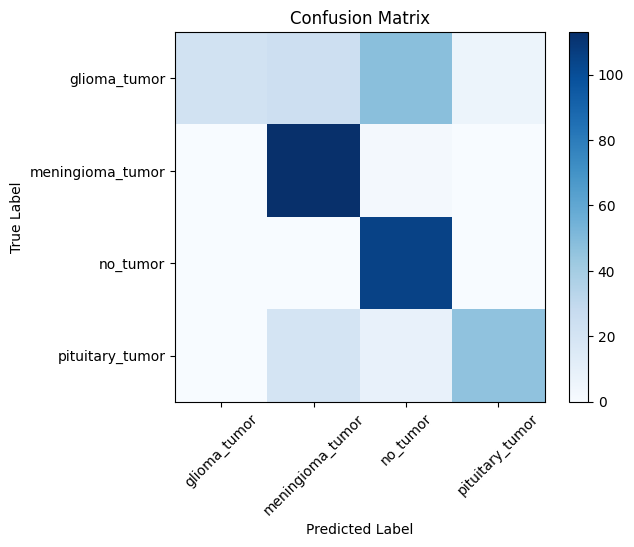

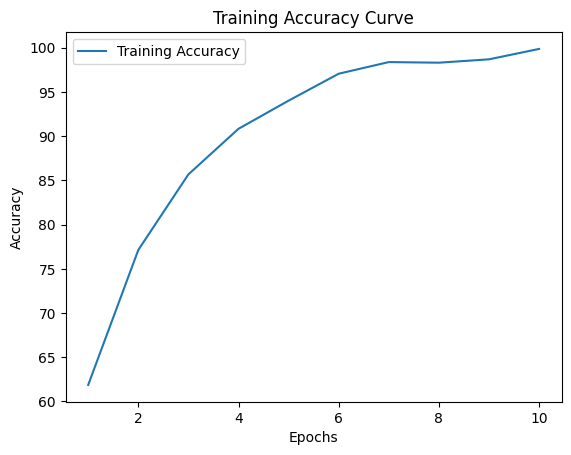

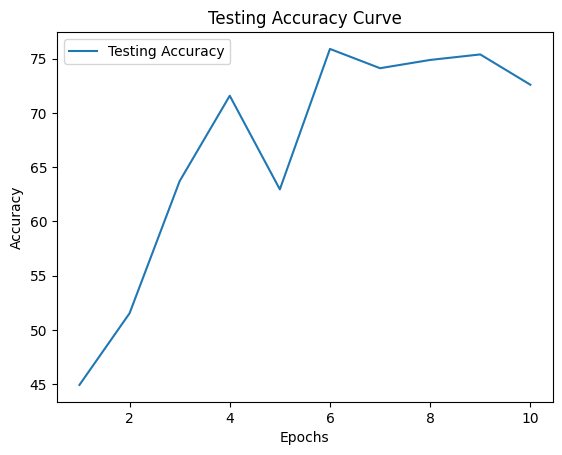

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to the overall training and testing datasets
dataset_train_path = "/content/drive/MyDrive/datasets/brain-tumour-dataset/Training"
dataset_test_path = "/content/drive/MyDrive/datasets/brain-tumour-dataset/Testing"

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Define pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the overall training and testing datasets
train_dataset = datasets.ImageFolder(root=dataset_train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_test_path, transform=transform)

# Define data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_accuracies = []
test_accuracies = []
num_epochs = 10

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_test = 0
    total_test = 0
    all_true_labels = []
    all_predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_true_labels.extend(labels.numpy())
            all_predicted_labels.extend(predicted.numpy())

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy}%, Testing Accuracy: {test_accuracy}%")

# Generate classification report
print("Classification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=test_dataset.classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(len(test_dataset.classes)), test_dataset.classes, rotation=45)
plt.yticks(np.arange(len(test_dataset.classes)), test_dataset.classes)
plt.show()

# Plot training accuracy curve
plt.plot(np.arange(1, num_epochs+1), train_accuracies, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()
plt.show()

# Plot testing accuracy curve
plt.plot(np.arange(1, num_epochs+1), test_accuracies, label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Testing Accuracy Curve")
plt.legend()
plt.show()
